In [1]:
%load_ext autoreload
%autoreload 2

## Imports

In [2]:
import pathlib
import pickle

import matplotlib.pyplot as plt
import tqdm
import torch
from torch import nn, optim
from torch.nn.functional import interpolate
from torch.utils.data import DataLoader
from torchvision.transforms.functional import adjust_brightness

from super_resolution.src.sen2venus_dataset import (
    create_train_validation_test_split,
    default_patch_transform,
)
from super_resolution.src.visualization import plot_gallery
from super_resolution.src.srgan import SRResNet, TruncatedVGG19

In [3]:
DATA_DIR = pathlib.Path("C:/Users/Mitch/stat3007_data")
SITES_DIR = DATA_DIR / "sites"
PREPROCESSING_DIR = DATA_DIR / "preprocessing"
RESULTS_DIR = DATA_DIR / "results"

In [4]:
sites = {
    "SO2",
    # "ES-LTERA",
    # "FR-LAM",
}
train_patches, val_patches, test_patches = create_train_validation_test_split(
    str(SITES_DIR) + "\\", sites=sites
)
print(
    f"Num train {len(train_patches)}\n"
    f"Num validation {len(val_patches)}\n"
    f"Num test {len(test_patches)}"
)

Num train 516
Num validation 111
Num test 111


In [152]:
# Count how many are unreliable
loader = DataLoader(train_patches, batch_size=1)
x_large_count = 0
x_small_count = 0
y_large_count = 0
y_small_count = 0
x_discard_count = 0
y_discard_count = 0
for x, y in tqdm.tqdm(loader, ncols=100, total=len(loader)):
    if x.max() > 1 or x.min() < 0:
        x_discard_count += 1

    if y.max() > 1 or y.min() < 0:
        y_discard_count += 1

    if x.max() > 1:
        x_large_count += 1

    if x.min() < 0:
        x_small_count += 1

    if y.max() > 1:
        y_large_count += 1

    if y.min() < 0:
        y_small_count += 1

100%|███████████████████████████████████████████████████████████| 6816/6816 [06:02<00:00, 18.78it/s]


In [156]:
x.max()

tensor(6.7369)

In [157]:
x.min()

tensor(-1.6863)

In [153]:
x_large_count, x_small_count, y_large_count, y_small_count

(6739, 6816, 5, 265)

In [155]:
x_discard_count / len(loader), y_discard_count / len(loader)

(1.0, 0.03961267605633803)

In [5]:
# Compute data mean and std for channels
train_patches.set_transform(lambda x, y: (x[:3, :, :], y[:3, :, :]))
loader = DataLoader(train_patches, batch_size=256)
channel_means = torch.zeros((3, 1, 1))
channel_std = torch.zeros((3, 1, 1))
hr_channel_means = torch.zeros((3, 1, 1))
hr_channel_std = torch.zeros((3, 1, 1))

for low_res, high_res in loader:
    channel_means += torch.mean(low_res, (0, 2, 3), keepdim=True).squeeze(0)
    channel_std += torch.std(low_res, (0, 2, 3), keepdim=True).squeeze(0)
    hr_channel_means += torch.mean(high_res, (0, 2, 3), keepdim=True).squeeze(0)
    hr_channel_std += torch.std(high_res, (0, 2, 3), keepdim=True).squeeze(0)

channel_means /= len(loader)
channel_std /= len(loader)
hr_channel_means /= len(loader)
hr_channel_std /= len(loader)

In [6]:
channel_means, hr_channel_means

(tensor([[[0.0480]],
 
         [[0.0763]],
 
         [[0.0792]]]),
 tensor([[[0.0477]],
 
         [[0.0758]],
 
         [[0.0793]]]))

In [7]:
channel_std, hr_channel_std

(tensor([[[0.0262]],
 
         [[0.0334]],
 
         [[0.0517]]]),
 tensor([[[0.0260]],
 
         [[0.0332]],
 
         [[0.0517]]]))

In [5]:
# def channel_scale(x, y):
#     x = x[:3, :, :]
#     y = y[:3, :, :]
#     x_channel_max = x.max(dim=1)[0].max(1)[0].unsqueeze(1).unsqueeze(1)
#     x_channel_min = x.min(dim=1)[0].min(1)[0].unsqueeze(1).unsqueeze(1)
#     y_channel_max = y.max(dim=1)[0].max(1)[0].unsqueeze(1).unsqueeze(1)
#     y_channel_min = y.min(dim=1)[0].min(1)[0].unsqueeze(1).unsqueeze(1)

#     x = (x - x_channel_min) / (x_channel_max - x_channel_min)
#     y = (y - y_channel_min) / (y_channel_max - y_channel_min)

#     return x, y


def channel_scale(x):
    x = x[:3, :, :]
    x_channel_max = x.max(dim=1)[0].max(1)[0].unsqueeze(1).unsqueeze(1)
    x_channel_min = x.min(dim=1)[0].min(1)[0].unsqueeze(1).unsqueeze(1)

    x = (x - x_channel_min) / (x_channel_max - x_channel_min)

    return x


def image_transform(x, y):
    x = x[:3, :, :]
    y = y[:3, :, :]

    x = torch.clamp(x, 0, 1)
    y = torch.clamp(y, 0, 1)

    # x = (x - channel_means) / channel_std
    # y = (y - hr_channel_means) / hr_channel_std

    return x, y

In [6]:
train_patches.set_transform(image_transform)
test_patches.set_transform(image_transform)

In [7]:
train_loader = DataLoader(train_patches, batch_size=2)

In [8]:
(low_res, high_res) = next(train_loader.__iter__())

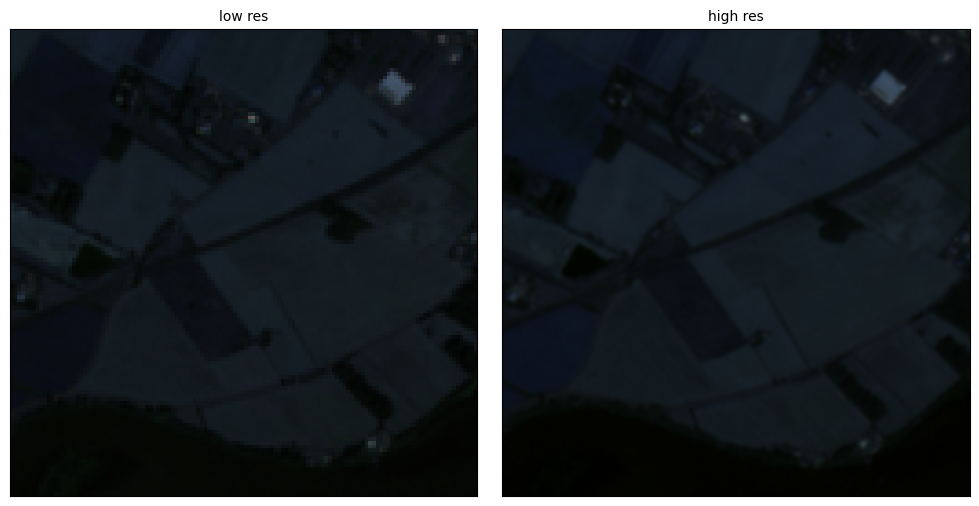

In [9]:
low_res_example = low_res[0]
high_res_example = high_res[0]
plot_gallery(
    [low_res_example.permute(1, 2, 0), high_res_example.permute(1, 2, 0)],
    titles=["low res", "high res"],
    xscale=5,
    yscale=5,
)

In [ ]:
# For clearing GPU memory
1 / 0

In [ ]:
# For clearing GPU memory
import gc

gc.collect()
torch.cuda.empty_cache()

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
torch.cuda.empty_cache()
should_pin_memory = {"cuda": True, "cpu": False}

train_loader = DataLoader(
    train_patches,
    shuffle=True,  # Always set to true for training
    batch_size=16,  # Always try to set as powers of 2
    drop_last=True,  # Ensures batch size is always the one given (Drops last if its is smaller)
    pin_memory=should_pin_memory[device.type],  # Faster push to GPU
    num_workers=0,  # Load data in parallel but costs more memory
)

In [11]:
device

device(type='cuda')

In [90]:
model = SRResNet(scaling_factor=2, n_blocks=4)

In [91]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.00001)

In [226]:
model = model.to(device)
model = model.train()

In [93]:
vgg = TruncatedVGG19().to(device)
vgg = vgg.eval()
vgg = vgg.requires_grad_(False)

In [94]:
NUM_EPOCHS = 50

In [95]:
losses = []
epoch_losses = []

In [241]:
for epoch in range(NUM_EPOCHS):
    progress_bar = tqdm.tqdm(train_loader, total=len(train_loader), ncols=100)
    epoch_loss = 0.0
    for low_res_batch, high_res_batch in progress_bar:
        # Push to GPU
        low_res_batch = low_res_batch.to(device)
        high_res_batch = high_res_batch.to(device)

        optimizer.zero_grad()

        # Loss and update
        out = model(low_res_batch).clamp(0, 1)
        # low_vgg = vgg(out)
        # high_vgg = vgg(high_res_batch).detach()
        # vgg_loss = criterion(low_vgg, high_vgg)
        pixel_loss = criterion(out, high_res_batch)
        loss = pixel_loss
        # loss = 100 * pixel_loss + 0.4 * vgg_loss
        loss.backward()
        optimizer.step()

        # Collect data
        epoch_loss += loss.item()
        losses.append(loss.item())
        progress_bar.set_postfix(epoch=epoch, batch_loss=loss.item())

    epoch_loss /= len(train_loader)
    epoch_losses.append(epoch_loss)
    print(f"Epoch: {epoch} / loss: {epoch_loss:.6f}")

  0%|                                                                        | 0/32 [00:00<?, ?it/s]


TypeError: '_IncompatibleKeys' object is not callable

In [201]:
len(epoch_losses)

156

In [202]:
epoch_losses[-5:]

[6.492909290045645e-05,
 5.8337174777989276e-05,
 6.13275009300196e-05,
 5.8067529494110204e-05,
 5.7252793112638756e-05]

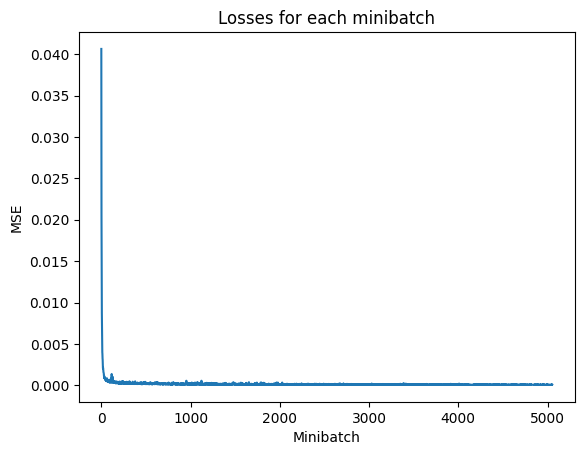

In [203]:
plt.plot(losses)
plt.title("Losses for each minibatch")
plt.xlabel("Minibatch")
plt.ylabel("MSE")
plt.show()

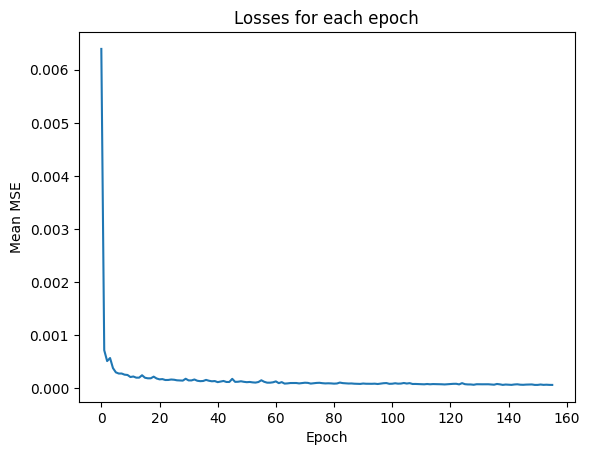

In [204]:
plt.plot(epoch_losses)
plt.title("Losses for each epoch")
plt.xlabel("Epoch")
plt.ylabel("Mean MSE")
plt.show()

In [228]:
experiment = {
    "epoch_losses": epoch_losses,
    "batch_losses": losses,
    "model_state": model.state_dict(),
    "optimizer_state": optimizer.state_dict(),
}
save_file = RESULTS_DIR / "abcslightlybeatbicubic_experiment_good.pkl"

In [229]:
torch.save(experiment, save_file)

In [237]:
loaded_experiment = torch.load(save_file)

In [244]:
loaded_model = SRResNet(n_blocks=4)
loaded_model.load_state_dict((loaded_experiment["model_state"]))

<All keys matched successfully>

In [230]:
loader = DataLoader(test_patches, batch_size=100)
(low_res, high_res) = next(train_loader.__iter__())

In [231]:
model = model.to("cpu")

In [232]:
channel_std = 1
channel_means = 0

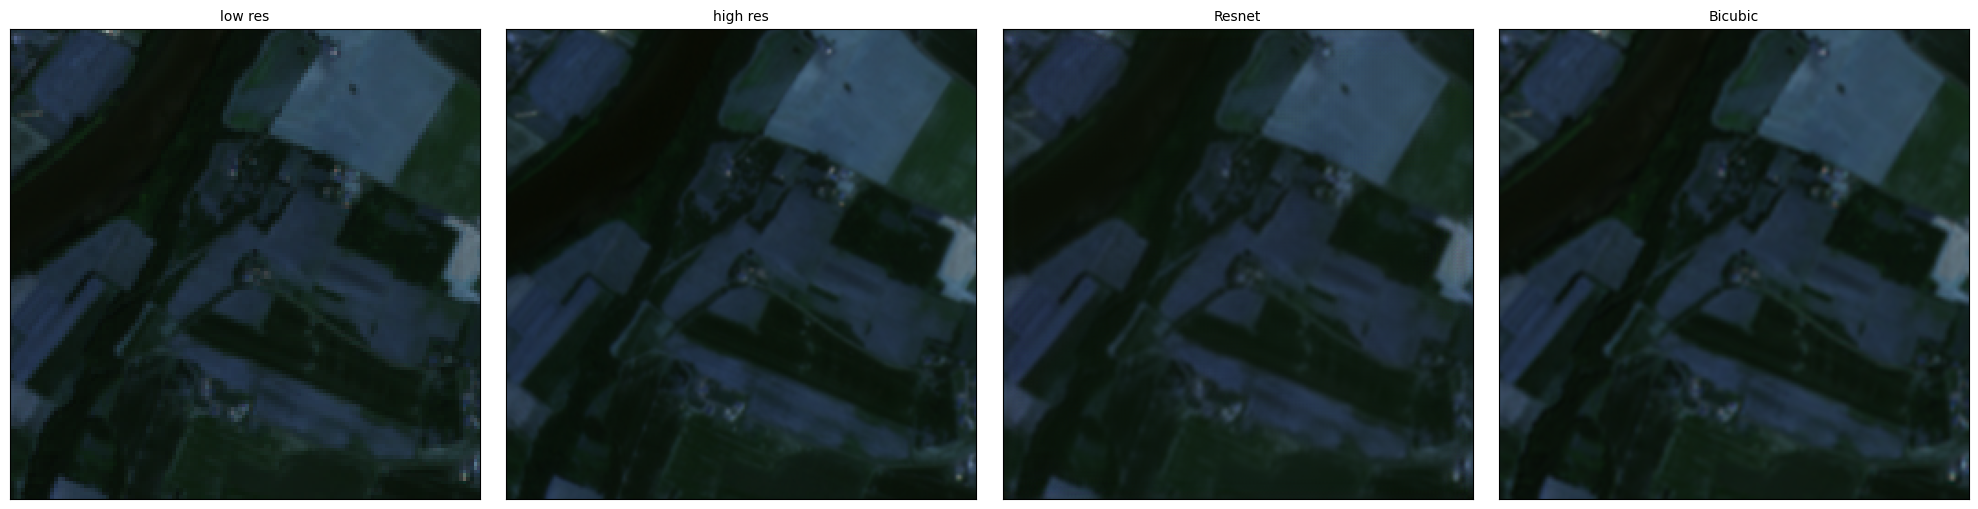

In [246]:
import random

index = random.randint(0, len(low_res) - 1)

low_res_example = low_res[index]
high_res_example = high_res[index]
out = model(low_res_example.unsqueeze(0)).detach().clamp(0, 1)
bicubic_out = interpolate(
    (low_res_example.unsqueeze(0) * channel_std + channel_means),
    size=(256, 256),
    mode="bicubic",
).float()
plot_gallery(
    [
        adjust_brightness(low_res_example * channel_std + channel_means, 2).permute(
            1, 2, 0
        ),
        adjust_brightness(high_res_example, 2).permute(1, 2, 0),
        adjust_brightness(out[0], 2).permute(1, 2, 0),
        adjust_brightness(bicubic_out[0], 2).permute(1, 2, 0),
    ],
    titles=["low res", "high res", "Resnet", "Bicubic"],
    xscale=5,
    yscale=5,
)

In [212]:
high_res_example.min(), low_res_example.min(), high_res_example.max(), low_res_example.max()

(tensor(0.0113), tensor(0.0149), tensor(0.3938), tensor(0.3820))

In [213]:
low_res_example.min()

tensor(0.0149)

In [214]:
loader = DataLoader(train_patches, batch_size=100)
(low_res, high_res) = next(train_loader.__iter__())

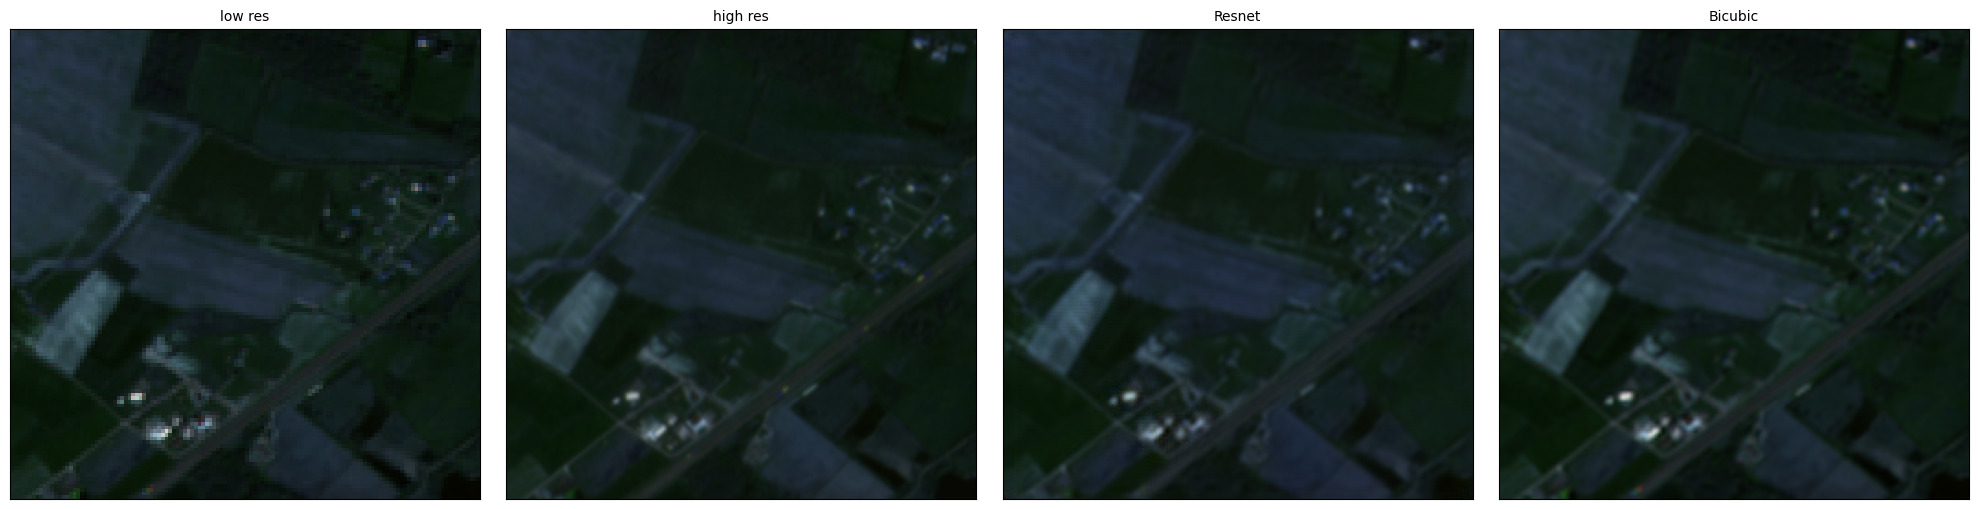

In [221]:
import random

index = random.randint(0, len(low_res) - 1)

low_res_example = low_res[index]
high_res_example = high_res[index]
out = model(low_res_example.unsqueeze(0)).detach().clamp(0, 1)
bicubic_out = (
    interpolate(low_res_example.unsqueeze(0), size=(256, 256), mode="bicubic")
    .float()
    .clamp(0, 1)
)
plot_gallery(
    [
        adjust_brightness(low_res_example, 2).permute(1, 2, 0),
        adjust_brightness(high_res_example, 2).permute(1, 2, 0),
        adjust_brightness(out[0], 2).permute(1, 2, 0),
        adjust_brightness(bicubic_out[0], 2).permute(1, 2, 0),
    ],
    titles=["low res", "high res", "Resnet", "Bicubic"],
    xscale=5,
    yscale=5,
)

In [63]:
low_res_example.max(), high_res_example.max()

(tensor(0.3410), tensor(0.3056))

In [222]:
from super_resolution.src.testing import compute_metrics

metric_loader = DataLoader(test_patches, batch_size=len(train_patches))
metrics = compute_metrics(lambda x: model(x).clamp(0, 1), metric_loader)

In [223]:
metrics

Metrics(mse=6.33377130725421e-05, psnr=41.983375549316406, ssim=0.9827128052711487)

In [224]:
bicubic_metrics = compute_metrics(
    lambda x: interpolate(x, size=(256, 256)), metric_loader
)

In [225]:
bicubic_metrics

Metrics(mse=7.11642496753484e-05, psnr=41.477378845214844, ssim=0.9729695916175842)